In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') +'/aiffel/stock_prediction/data/samsung.csv'
df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [3]:
# Date 를 index_col 로 지정

df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [4]:
# Close 만사용하기로 함

ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

In [5]:
#결측치 확인

ts[ts.isna()]

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [6]:
#결측치 처리

ts = ts.interpolate(method = 'time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

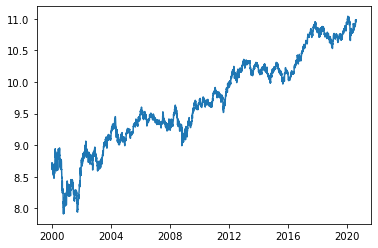

In [7]:
#로그변환

ts_log = np.log(ts)
plt.plot(ts_log)

In [8]:
#정성적 그래프 분석 : plot_rolling_statistics(ts_log, window = 12)
#정량적 Augmented Dicky-Fuller Test(ts_log)
#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model = 'multiplicative', period = 30)

In [9]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

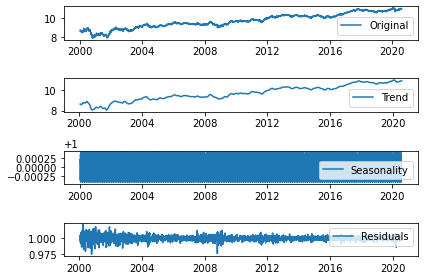

In [10]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
def plot_rolling_statistics(timeseries, window =12):
    rolmean = timeseries.rolling(window=window).mean() #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() #이동표준편차 시계열
    
    #원본시계열, 이동평균, 이동표준편차를 plot 으로 시각화 해보자
    
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black' , label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block =False)
    
from statsmodels.tsa.stattools import adfuller
    
def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    #adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '#Lags Used', 
                                              'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    


In [12]:
#Residual 안정성 확인

residual.dropna(inplace = True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistics               -1.728531e+01
p-value                        5.748521e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


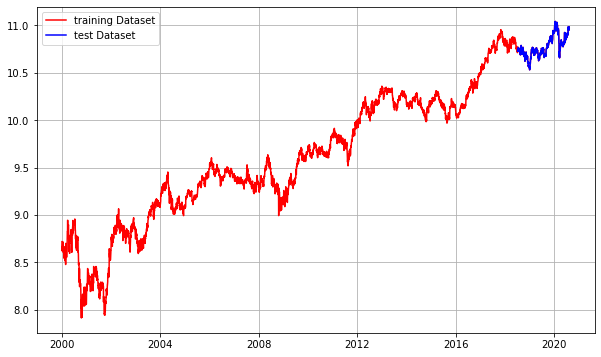

In [13]:
#학습 데이터 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training Dataset')
plt.plot(test_data, c = 'b' , label = 'test Dataset')
plt.legend()

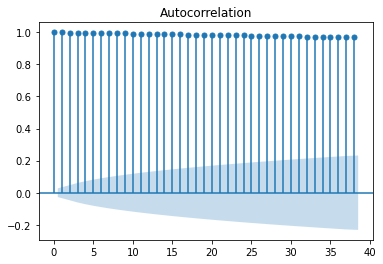

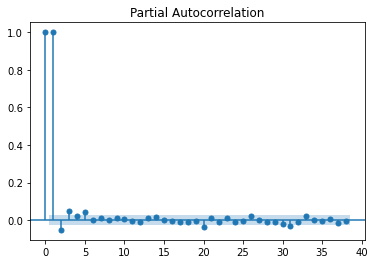

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) #ACF
plot_pacf(ts_log) #PACF

plt.show()

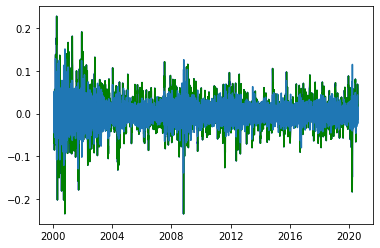

In [15]:
moving_avg = ts_log.rolling(window=12).mean()
ts_log_moving_avg = ts_log - moving_avg

ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color = 'blue')
plt.plot(ts_log_moving_avg_shift, color = 'green')

ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace = True)
plt.plot(ts_log_moving_avg_diff)

In [16]:
# ARIMA 훈련 및 플로팅

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order = (1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                         -21960.569
Time:                        14:40:15   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


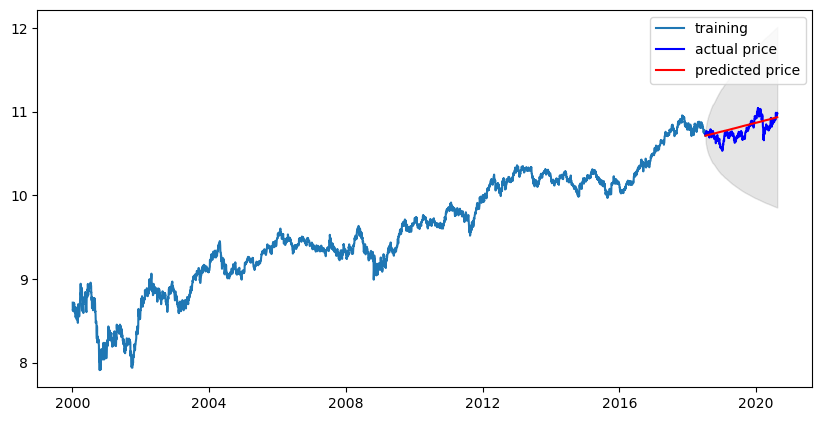

In [17]:
# Forecast : 결과가 fc 에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05) #95% conf

# Make as pandas series

fc_series = pd.Series(fc, index = test_data.index) #예측결과
lower_series = pd.Series(conf[:, 0], index = test_data.index) #예측결과의 하향바운드
upper_series = pd.Series(conf[:,1], index = test_data.index)  #예측결과의 하향바운드

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data, label = 'training')
plt.plot(test_data, c = 'b', label = 'actual price')
plt.plot(fc_series, c = 'r', label = 'predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color = 'k', alpha =0.1)
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ' , mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ' , rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE:{:.2f}%'.format(mape*100))

MSE:  18516817.271092057
MAE:  3589.9973236536266
RMSE:  4303.117157490841
MAPE:7.68%





# 2  KAKAO 로 해보기





In [19]:
dataset_filepath2 = os.getenv('HOME') +'/aiffel/stock_prediction/data/kakao.csv'
df2 = pd.read_csv(dataset_filepath2, index_col = 'Date', parse_dates = True)
df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-14,133000.0,133000.0,129000.0,130500.0,130500.0,338519.0
2019-08-16,129500.0,130000.0,128000.0,129500.0,129500.0,300046.0
2019-08-19,130500.0,131500.0,129500.0,130500.0,130500.0,222446.0
2019-08-20,131000.0,132000.0,129500.0,132000.0,132000.0,369383.0
2019-08-21,131000.0,133000.0,130500.0,131500.0,131500.0,284628.0


In [20]:
ts2 = df2['Close']
ts2.head()

Date
2019-08-14    130500.0
2019-08-16    129500.0
2019-08-19    130500.0
2019-08-20    132000.0
2019-08-21    131500.0
Name: Close, dtype: float64

In [21]:
ts2 = ts2.interpolate(method = 'time')
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

In [22]:
ts2_log = np.log(ts2)

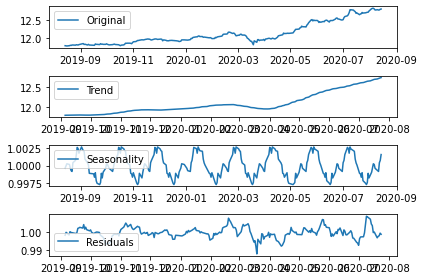

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

#decomposition2 = seasonal_decompose(ts2_log, model = 'additive', period = 30)
decomposition2 = seasonal_decompose(ts2_log, model = 'multiplicative', period = 30)

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [24]:
#Residual 확인

residual2.dropna(inplace = True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistics                 -5.456398
p-value                          0.000003
#Lags Used                       3.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


Results of Dickey-Fuller Test:
Test Statistics               -7.754474e+00
p-value                        9.820875e-12
#Lags Used                     6.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


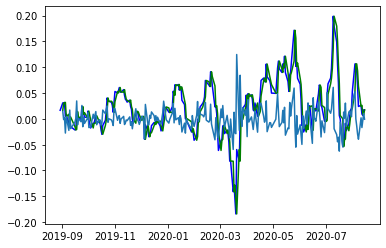

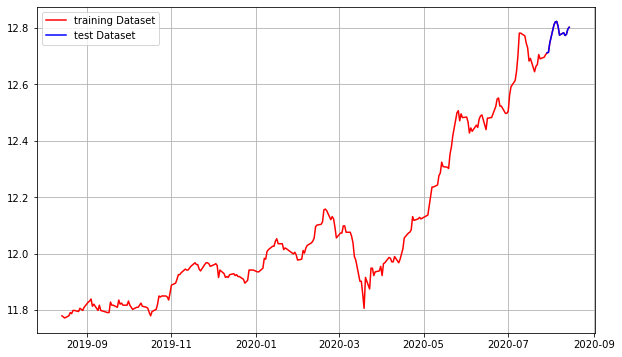

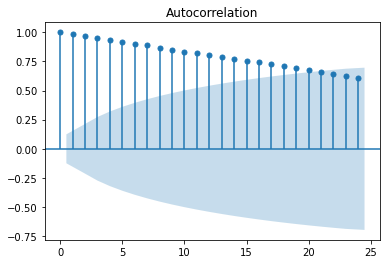

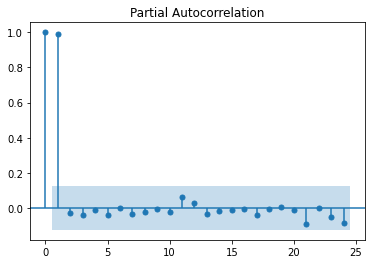

In [25]:
moving_avg = ts2_log.rolling(window=12).mean()
ts2_log_moving_avg = ts2_log - moving_avg

ts2_log_moving_avg_shift = ts2_log_moving_avg.shift()

plt.plot(ts2_log_moving_avg, color = 'blue')
plt.plot(ts2_log_moving_avg_shift, color = 'green')

ts2_log_moving_avg_diff = ts2_log_moving_avg - ts2_log_moving_avg_shift
ts2_log_moving_avg_diff.dropna(inplace = True)
plt.plot(ts2_log_moving_avg_diff)
augmented_dickey_fuller_test(ts2_log_moving_avg_diff)

#학습 데이터 분리

train_data2, test_data2 = ts2_log[:int(len(ts2_log)*0.95)] , ts2_log[int(len(ts2_log)*0.95):]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts2_log, c = 'r', label = 'training Dataset')
plt.plot(test_data2, c = 'b' , label = 'test Dataset')
plt.legend()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log) #ACF
plot_pacf(ts2_log) #PACF

plt.show()

In [26]:
# ARIMA 훈련 및 플로팅

from statsmodels.tsa.arima_model import ARIMA

model2 = ARIMA(train_data2, order = (1,1,0))
fitted_m2 = model2.fit(disp=-1)
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  235
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 548.893
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                          -1091.786
Time:                        14:40:22   BIC                          -1081.407
Sample:                             1   HQIC                         -1087.602
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.002      2.501      0.012       0.001       0.007
ar.L1.D.Close     0.0311      0.065      0.478      0.633      -0.096       0.159
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


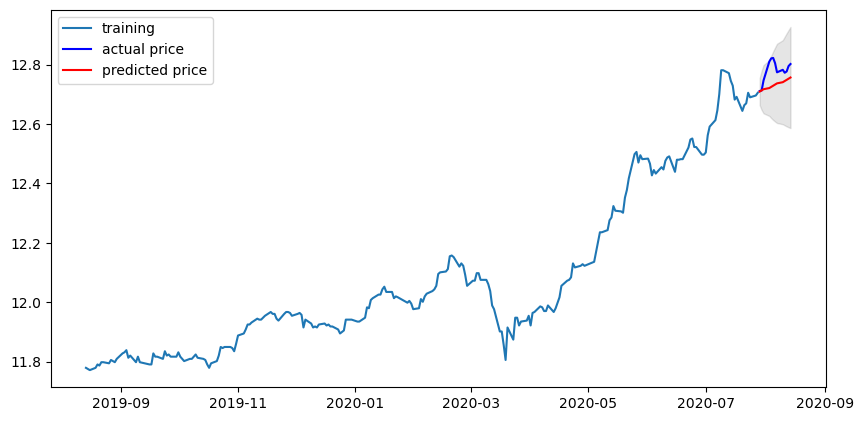

In [27]:
# Forecast : 결과가 fc 에 담깁니다.
fc2, se2, conf2 = fitted_m2.forecast(len(test_data2), alpha = 0.05) #95% conf

# Make as pandas series

fc2_series = pd.Series(fc2, index = test_data2.index) #예측결과
lower2_series = pd.Series(conf2[:,0], index = test_data2.index) #예측결과의 하향바운드
upper2_series = pd.Series(conf2[:,1], index = test_data2.index)  #예측결과의 하향바운드

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data2, label = 'training')
plt.plot(test_data2, c = 'b', label = 'actual price')
plt.plot(fc2_series, c = 'r', label = 'predicted price')
plt.fill_between(lower2_series.index, lower2_series, upper2_series, color = 'k', alpha =0.1)
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ' , mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ' , rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE:{:.2f}%'.format(mape2*100))

MSE:  385099046.37312704
MAE:  16332.012500409472
RMSE:  19623.94064333479
MAPE:4.51%


# NVIDIA 로 해보기

In [49]:
dataset_filepath3 = os.getenv('HOME') +'/aiffel/stock_prediction/data/nvidia.csv'
df3 = pd.read_csv(dataset_filepath3, index_col = 'Date', parse_dates = True)
df3.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,1.750000,1.953125,1.552083,1.640625,1.509309,67867200
1999-01-25,1.770833,1.833333,1.640625,1.812500,1.667427,12762000
1999-01-26,1.833333,1.869792,1.645833,1.671875,1.538057,8580000
1999-01-27,1.677083,1.718750,1.583333,1.666667,1.533266,6109200
1999-01-28,1.666667,1.677083,1.651042,1.661458,1.528475,5688000


In [50]:
ts3 = df3['Close']
ts3.head()
ts3[ts3.isnull()]

Series([], Name: Close, dtype: float64)

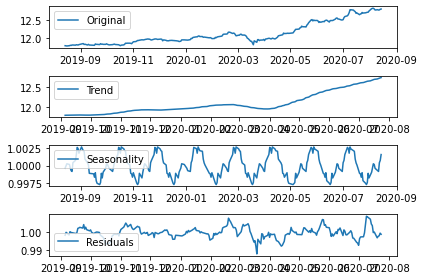

In [51]:
ts3_log = np.log(ts3)

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition3 = seasonal_decompose(ts3_log, model = 'additive', period = 30)
#decomposition3 = seasonal_decompose(ts3_log, model = 'multiplicative', period = 30)

trend3 = decomposition3.trend
seasonal3 = decomposition3.seasonal
residual3 = decomposition3.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [52]:
#Residual 확인

residual3.dropna(inplace = True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistics               -1.836011e+01
p-value                        2.228073e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.362000e+03
Critical Value (1%)           -3.431570e+00
Critical Value (5%)           -2.862079e+00
Critical Value (10%)          -2.567057e+00
dtype: float64


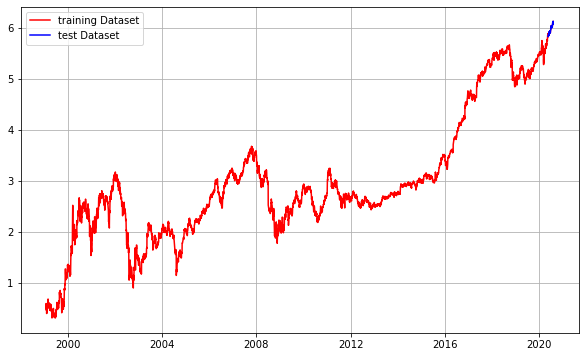

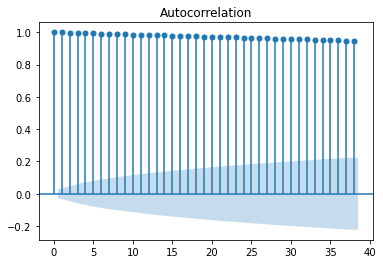

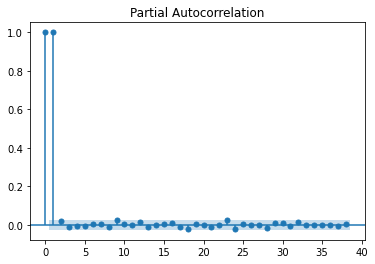

In [53]:
#학습 데이터 분리

train_data3, test_data3 = ts3_log[:int(len(ts3_log)*0.99)] , ts3_log[int(len(ts3_log)*0.99):]

plt.figure(figsize = (10,6))
plt.grid(True)
plt.plot(ts3_log, c = 'r', label = 'training Dataset')
plt.plot(test_data3, c = 'b' , label = 'test Dataset')
plt.legend()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log) #ACF
plot_pacf(ts3_log) #PACF

plt.show()

In [54]:
# ARIMA 훈련 및 플로팅

from statsmodels.tsa.arima_model import ARIMA

model3 = ARIMA(train_data3, order = (1,1,0))
fitted_m3 = model3.fit(disp=-1)
print(fitted_m3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5369
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9843.247
Method:                       css-mle   S.D. of innovations              0.039
Date:                Fri, 14 Aug 2020   AIC                         -19680.493
Time:                        14:44:00   BIC                         -19660.728
Sample:                             1   HQIC                        -19673.591
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.884      0.060   -4.03e-05       0.002
ar.L1.D.Close     0.0036      0.014      0.266      0.790      -0.023       0.030
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


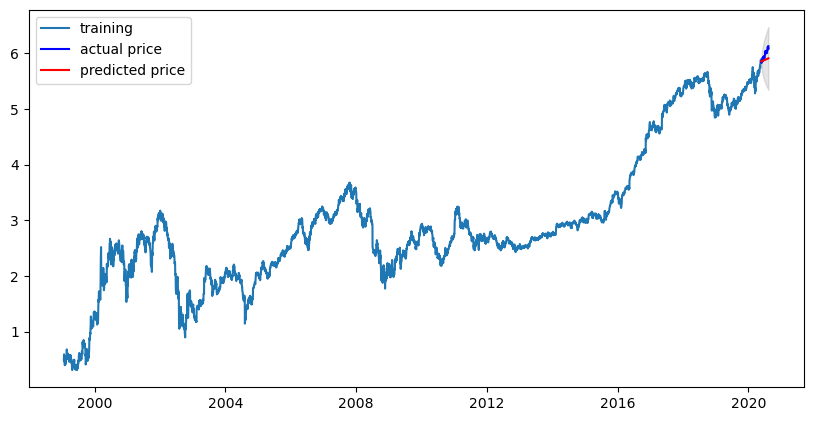

In [55]:
# Forecast : 결과가 fc 에 담깁니다.
fc3, se3, conf3 = fitted_m3.forecast(len(test_data3), alpha = 0.05) #95% conf

# Make as pandas series

fc3_series = pd.Series(fc3, index = test_data3.index) #예측결과
lower3_series = pd.Series(conf3[:,0], index = test_data3.index) #예측결과의 하향바운드
upper3_series = pd.Series(conf3[:,1], index = test_data3.index)  #예측결과의 하향바운드

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_data3, label = 'training')
plt.plot(test_data3, c = 'b', label = 'actual price')
plt.plot(fc3_series, c = 'r', label = 'predicted price')
plt.fill_between(lower3_series.index, lower3_series, upper3_series, color = 'k', alpha =0.1)
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse3 = mean_squared_error(np.exp(test_data3), np.exp(fc3))
print('MSE: ', mse3)

mae3 = mean_absolute_error(np.exp(test_data3), np.exp(fc3))
print('MAE: ' , mae3)

rmse3 = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3)))
print('RMSE: ' , rmse3)

mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE:{:.2f}%'.format(mape3*100))

MSE:  1971.662582070209
MAE:  35.51730910917189
RMSE:  44.40340732500389
MAPE:8.54%


저는 우선 첫번째는 기본데이터인 Samsung, 두번째는 Kakao, 세번째는 Shell 사를 선택하였습니다.

첫번째 데이터와 달리 두번째, 세번째 데이터를 포함한 많은 데이터들의 MAPE 가 너무 높게 나왔었습니다.

제가 생각한 이유는 MAX 로 받은 데이터에 최근 코로나 사태로 인해 급증/급감 한 데이터에 대한 정확한 예측이 어려웠습니다.

모든 데이터가 그런것은 아니지만, 여러 데이터를 넣어본 결과 ACF, PACF 그래프를 돌려 구한 p,q,d 값은 크게 영향을 끼치지 못하였습니다.

그렇기 때문에, 저는 방대한 데이터는 우선 1. 데이터 값 자체를 원하는 구간으로 자르거나  2. Train data, Test data 량 자체를 줄이는것 이었습니다.

그래서 2번째는 KAKAO 주식의 데이터값 (MAX 로 받지 않고 그냥 default 값으로 받았습니다) 을 조정하고, train, test 를 0.95 즉 끝에 5프로 에 대한 예측을 실행하였습니다.

3번째는 NVIDIA 를 선택하였고, NVIDIA 는 MAX 로 받았지만 train, test 값을 조정해 돌려보았습니다. 